In [1]:
import pandas as pd
import xlwings as xw
from pathlib import Path
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pickle
import time
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import itertools

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

### Data Analysis

In [2]:
pth_1 = '../data/extract/p_labels.csv'
pth_2  = '../data/extract/full_output.csv'
df1 = pd.read_csv(pth_1)
df2 = pd.read_csv(pth_2)
df2 = df2[~df2['grpcis'].str.contains('[a-zA-Z]')]
df2['grpcis'] = df2['grpcis'].astype(float)
df2['customer_no'] = df2['customer_no'].astype(float)
# display(df1.info())
# display(df2.info())
df_f  = pd.merge(df2, df1[['grpcis', 'customer_no', 'director_name', 'label']], how='left', left_on=['grpcis', 'customer_no', 'director_name'], right_on=['grpcis', 'customer_no', 'director_name'])
# display(df_f.info())

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56858 entries, 0 to 56858
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   grpcis              56858 non-null  float64
 1   customer_no         56858 non-null  float64
 2   director_name       56853 non-null  object 
 3   passport_number     36384 non-null  object 
 4   visa_no             21074 non-null  object 
 5   mobile_1            23022 non-null  float64
 6   mobile_2            15776 non-null  float64
 7   e_mail              14061 non-null  object 
 8   national_id_number  211 non-null    object 
 9   age                 40440 non-null  float64
 10  id                  56848 non-null  float64
 11  group               56849 non-null  object 
 12  fuzzy_grp_nms_f     56847 non-null  object 
 13  dob                 4 non-null      object 
dtypes: float64(6), object(8)
memory usage: 6.5+ MB


In [4]:
df1.shape

(7150, 13)

In [5]:
cls = ['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms', 'label']
df1_new = df1[cls]
df1_new.replace({False:0, True:1}, inplace=True)

In [6]:
class_names = df1_new['label'].unique()
display(class_names)

labels, counts = np.unique(df1_new['label'], return_counts=True)
display(labels, counts)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array([ 921, 6229], dtype=int64)

In [7]:
df1_new['label'].value_counts()

1    6229
0     921
Name: label, dtype: int64

### Final Model 

In [8]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode
        # cat_cols = ['director_name', 'fuzzy_grp_nms']
        

    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = preprocessing.LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

##### Model definitions

In [9]:
class models:

    def __init__(self, train_x, train_y, test_x, test_y):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y

    def randomforest(self):
        # Fit the classifier
        classifier = RandomForestClassifier().fit(self.train_x, self.train_y)
        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(self.test_x)

        return predicted_labels
    def supportvectormachine(self):
        # Fit the classifier
        classifier = svm.SVC().fit(self.train_x, self.train_y)
        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(self.test_x)

        return predicted_labels

    def xgb_boost(self):
        # Fit the classifier
        classifier = XGBClassifier().fit(self.train_x, self.train_y)
         # Predict the labels of the test set samples
        predicted_labels = classifier.predict(self.test_x)

        return predicted_labels      


In [10]:
class algorithm:

    def __init__(self, name=None, path=None ,cat_cols=None):
        self.model_type = name
        # self.data_x = X
        # self.data_y = y
        # self.class_nms = class_nms
        self.cat_cols = cat_cols  # cat_cols = ['director_name', 'fuzzy_grp_nms']
        self.path = path

    def data_curation(self):
        # pth_1 = '../data/extract/p_labels.csv'
        # pth_2  = '../data/extract/full_output.csv'
        df1 = pd.read_csv(self.path)
        cls = ['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms', 'label']
        df1_new = df1[cls]
        df1_new.replace({False:0, True:1}, inplace=True)
        class_names = df1_new['label'].unique()
        X, y = df1_new[['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms']], df1_new[['label']]
        multi = MultiColumnLabelEncoder(columns=self.cat_cols)
        X_enc = multi.fit_transform(X)

        return X_enc, y, class_names
        
        # display(class_names)

    def evaluate_model(self, data_x, data_y):
        k_fold = KFold(10, shuffle=True, random_state=1)

        predicted_targets = np.array([])
        actual_targets = np.array([])
        print(f'Model Type:{self.model_type}...')
        for train_ix, test_ix in k_fold.split(data_x):
            train_x, train_y, test_x, test_y = data_x.iloc[train_ix], data_y.iloc[train_ix], data_x.iloc[test_ix], data_y.iloc[test_ix]

            # # Fit the classifier
            # classifier = svm.SVC().fit(train_x, train_y)

            # # Predict the labels of the test set samples
            # predicted_labels = classifier.predict(test_x)

            model_obj = models(train_x, train_y, test_x, test_y)
            if self.model_type == 'svm':
                # print(f'{self.model_type}')
                predicted_labels = model_obj.supportvectormachine()
                predicted_targets = np.append(predicted_targets, predicted_labels)
                actual_targets = np.append(actual_targets, test_y)

            elif self.model_type == 'randomforest':
                # print(self.model_type)
                predicted_labels = model_obj.randomforest()
                predicted_targets = np.append(predicted_targets, predicted_labels)
                actual_targets = np.append(actual_targets, test_y)

            elif self.model_type == 'xgb':
                # print(self.model_type)
                predicted_labels = model_obj.xgb_boost()
                predicted_targets = np.append(predicted_targets, predicted_labels)
                actual_targets = np.append(actual_targets, test_y)


        return predicted_targets, actual_targets

    def generate_confusion_matrix(self,cnf_matrix, classes, normalize=False, title='Confusion matrix'):
        if normalize:
            cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
        plt.title(title)
        plt.colorbar()

        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cnf_matrix.max() / 2.

        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        return cnf_matrix

    # report performance
    def plot_confusion_matrix(self, predicted_labels_list, y_test_list, class_nms):
        cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
        # print(cnf_matrix)
        # FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
        # FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        # TP = np.diag(cnf_matrix)
        # TN = cnf_matrix.sum() - (FP + FN + TP)
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        # TN = cnf_matrix.values.sum() - (FP + FN + TP)

        print(f'False Positive:{FP}\nFalse Negative:{FN}\nTruePositive:{TP}\nPrecision:{PPV}\nRecall or HitRate:{TPR}\
        \nFalse discovery rate:{FDR}\nFalse negative rate:{FNR}\nOverall Accuracy:{ACC}')
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        self.generate_confusion_matrix(cnf_matrix, classes=class_nms, title='Confusion matrix, without normalization')
        plt.show()

        # Plot normalized confusion matrix
        plt.figure()
        self.generate_confusion_matrix(cnf_matrix, classes=class_nms, normalize=True, title='Normalized confusion matrix')
        plt.show()
        print('_________________________________________________________________')

    

### Training on whole data

In [16]:
class model_selection:

    def __init__(self,name, path, cat_cols, model_path,full_path=None):
        self.model_name = name
        self.path = path
        self.full_path =full_path
        self.cat_cols = cat_cols
        self.model_path = model_path

    def data_curation(self):
        # pth_1 = '../data/extract/p_labels.csv'
        # pth_2  = '../data/extract/full_output.csv'
        df1 = pd.read_csv(self.path)
        cls = ['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms', 'label']
        df1_new = df1[cls]
        df1_new.replace({False:0, True:1}, inplace=True)
        class_names = df1_new['label'].unique()
        X, y = df1_new[['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms']], df1_new[['label']]
        multi = MultiColumnLabelEncoder(columns=self.cat_cols)
        X_enc = multi.fit_transform(X)

        return X_enc, y, df1_new

    def data_curation_full(self):
        print(self.full_path,'.....')
        df = pd.read_csv(self.full_path)
        df = df[~df['grpcis'].str.contains('[a-zA-Z]')]
        df['grpcis'] = df['grpcis'].astype(float)
        df['customer_no'] = df['customer_no'].astype(float)
        df.rename(columns={'fuzzy_grp_nms_f': 'fuzzy_grp_nms'}, inplace=True)
        cls = ['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms']
        df = df[cls]
        # df.replace({False:0, True:1}, inplace=True)
        X = df[['grpcis', 'customer_no', 'director_name', 'fuzzy_grp_nms']]
        multi = MultiColumnLabelEncoder(columns=self.cat_cols)
        X_enc = multi.fit_transform(X)

        return X_enc, df

    def save_model(self, file_nm, classifier):
        path = self.model_path+'/'+file_nm
        with open(path, 'wb') as f:
            pickle.dump(classifier, f)

    def load_model(self, model):
        for m_nms in os.listdir(self.model_path):
            # print(m_nms)
            if m_nms.startswith(model):
                print(f'{model} selected...')
                path = self.model_path+'/'+m_nms
                with open(path, 'rb') as f:
                    clf = pickle.load(f)

        return clf

    def to_export(self, file_name, out, exp_path):
        fname = lambda : "{}_{}.csv".format(file_name, time.strftime("%Y%m%d-%H.%M.%S"))
        path = os.path.join(exp_path, fname())
        return out.to_csv(path, index=False)

    def predict(self,class_model, x):
        predicted_labels = class_model.predict(x)
        return  predicted_labels

    def final_output(self, classifier, X_enc, out, file_name, exp_path):
        labels = self.predict(classifier, X_enc)
        print('Predicted all labels...')
        out['pred_labels'] = labels
        self.to_export(file_name, out, exp_path)
        return out, labels
        

    def evaluate(self, train_x, train_y):
        
        if self.model_name == 'svm':
            print(f'Model Type:{self.model_name}.....')
            classifier = svm.SVC().fit(train_x, train_y)
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = cv)
            self.save_model('svm_model.pickle', classifier)
            print('SVM Model saved...')
            # print("Mean_SVM_Acc : ", accuracies.mean())
            # report performance
            print('SVM accuracy: %.3f (%.3f)' % (mean(accuracies), std(accuracies)))

        if self.model_name == 'rf':
            print(f'Model Type:{self.model_name}.....')
            classifier = RandomForestClassifier().fit(train_x, train_y)
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = cv)
            self.save_model('rf_model.pickle', classifier)
            print('Random Forest Model saved...')
            # print("Mean_RandomForest_Acc : ", accuracies.mean())
            # report performance
            print('Rf accuracy: %.3f (%.3f)' % (mean(accuracies), std(accuracies)))

        if self.model_name == 'xgb':
            print(f'Model Type:{self.model_name}.....')
            classifier = XGBClassifier().fit(train_x, train_y)
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = cv)
            # print("Mean_XGB_Acc : ", accuracies.mean())
            # report performance
            self.save_model('xgb_model.pickle' , classifier)
            print('XGB Model saved...')
            print('XGB accuracy: %.3f (%.3f)' % (mean(accuracies), std(accuracies)))


### Testing all Model Accuracies

In [12]:
def run(m_types):
    
    for i in m_types:
        cat_cols = ['director_name', 'fuzzy_grp_nms']
        model_obj = algorithm(i,'../data/extract/p_labels.csv', cat_cols)
        X_enc, y, class_names = model_obj.data_curation()
        predicted_target, actual_target = model_obj.evaluate_model(X_enc, y)
        model_obj.plot_confusion_matrix(predicted_target, actual_target, class_names)

Model Type:svm...
False Positive:921
False Negative:0
TruePositive:6229
Precision:0.8711888111888112
Recall or HitRate:1.0        
False discovery rate:0.1288111888111888
False negative rate:0.0
Overall Accuracy:0.8711888111888112
Confusion matrix, without normalization


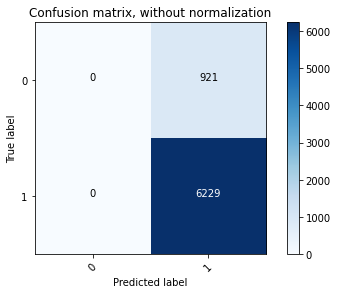

Normalized confusion matrix


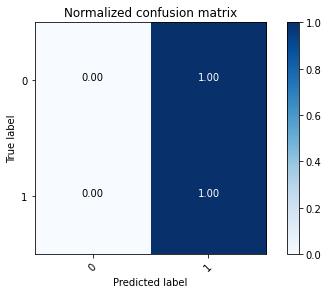

_________________________________________________________________
Model Type:randomforest...
False Positive:353
False Negative:136
TruePositive:6093
Precision:0.9452373565001552
Recall or HitRate:0.9781666399100979        
False discovery rate:0.05476264349984487
False negative rate:0.02183336008990207
Overall Accuracy:0.9316083916083916
Confusion matrix, without normalization


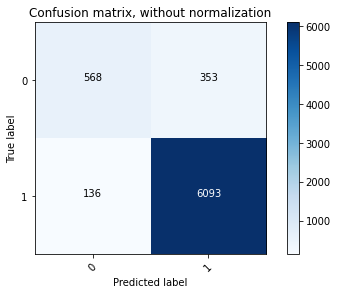

Normalized confusion matrix


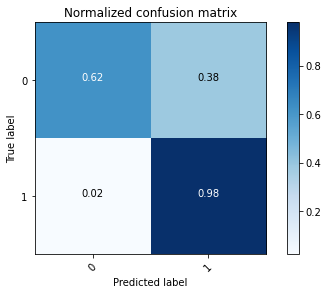

_________________________________________________________________
Model Type:xgb...
False Positive:406
False Negative:81
TruePositive:6148
Precision:0.9380530973451328
Recall or HitRate:0.9869963075935142        
False discovery rate:0.061946902654867256
False negative rate:0.013003692406485792
Overall Accuracy:0.9318881118881119
Confusion matrix, without normalization


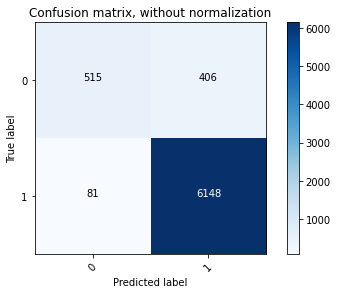

Normalized confusion matrix


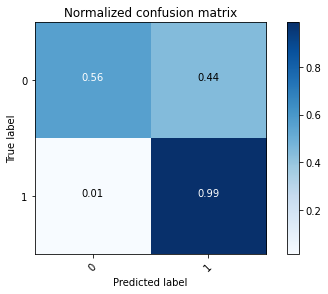

_________________________________________________________________


In [13]:
m_types = ['svm', 'randomforest', 'xgb']
run(m_types)

### Training on whole data and saving it

In [17]:
cat_cols = ['director_name', 'fuzzy_grp_nms']
model_path = '../model'
for i in ['svm', 'rf', 'xgb']:
    m_obj = model_selection(i, '../data/extract/p_labels.csv', cat_cols, model_path)
    X_enc, y, df_new = m_obj.data_curation()
    m_obj.evaluate(X_enc,y)

Model Type:svm.....
SVM Model saved...
SVM accuracy: 0.871 (0.000)
Model Type:rf.....
Random Forest Model saved...
Rf accuracy: 0.934 (0.009)
Model Type:xgb.....
XGB Model saved...
XGB accuracy: 0.934 (0.008)


### Predict all labels

### Labelled data

In [28]:
cat_cols = ['director_name', 'fuzzy_grp_nms']
f_obj = model_selection(i, '../data/extract/p_labels.csv', cat_cols, model_path, '../data/extract/full_output.csv')
X_enc, y, df = f_obj.data_curation()
model = f_obj.load_model('svm')
print(model)
df_out, labels = f_obj.final_output(model, X_enc, df, 'persona_label_sample', '../data/output')


svm selected...
SVC()
Predicted all labels...


#### Confusion Matrix

In [29]:
class_names = y['label'].unique()
class_names

array([0, 1], dtype=int64)

False Positive:921
False Negative:0
TruePositive:6229
Precision:0.8711888111888112
Recall or HitRate:1.0        
False discovery rate:0.1288111888111888
False negative rate:0.0
Overall Accuracy:0.8711888111888112
Confusion matrix, without normalization


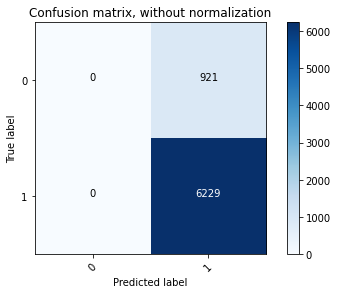

Normalized confusion matrix


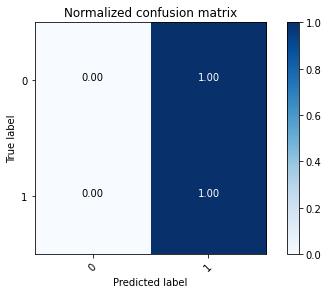

_________________________________________________________________


In [30]:
conf_mat = algorithm()
conf_mat.plot_confusion_matrix(labels, y, class_names)

#### Whole data

In [99]:
cat_cols = ['director_name', 'fuzzy_grp_nms']
f_obj = model_selection(i, '../data/extract/p_labels.csv', cat_cols, model_path, '../data/extract/full_output.csv')
X_enc, df = f_obj.data_curation_full()
model = f_obj.load_model('svm')
print(model)
df_out, labels = f_obj.final_output(model, X_enc, df, 'persona_label', '../data/output')


../data/extract/full_output.csv .....
svm selected...
SVC()
Predicted all labels...


### Report

In [109]:
np.unique(labels)

array([0, 1])

In [110]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7150 entries, 0 to 7149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grpcis         7150 non-null   float64
 1   customer_no    7150 non-null   float64
 2   director_name  7150 non-null   object 
 3   fuzzy_grp_nms  7150 non-null   object 
 4   label          7150 non-null   int64  
 5   pred_labels    7150 non-null   int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 307.4+ KB


In [112]:
data = pd.read_csv('../data/output/persona_label_sample_20220519-16.52.19.csv')
display(data['label'].value_counts())
display(data['pred_labels'].value_counts())

1    6229
0     921
Name: label, dtype: int64

1    6519
0     631
Name: pred_labels, dtype: int64

In [114]:
data['validation'] = np.where(data['label']==data['pred_labels'], True, False)

In [116]:
data.to_csv('../data/report/personal_labelled_data.csv', index=False)